In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
from matplotlib import colors as mcolors
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
# functions needed for data prep

def time_of_day(hour):
    if hour<6:
        return "night"
    elif hour<10:
        return "morning rush"
    elif hour<16:
        return "daytime"
    elif hour<19:
        return "evening_rush"
    else:
        return "night"
    
def checkWeekday(day):
    n = day.isoweekday()
    if n<6:
        return 1
    else:
        return 0
    
def groupMinSinceMidnight(m):
    for minInt in range(0, 1445, 30):
        if m < minInt:
            return minInt

In [3]:
def importAndPrepareData(filepath):
    # check if tsv or csv
    impdf = pd.read_csv(filepath, delimiter=',')
    datetimeCol = [col for col in impdf.columns if 'datetime' in col]
    impdf['datetime'] = impdf[datetimeCol[0]].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    impdf = impdf.set_index('datetime')
    impdf = impdf.reset_index()
    
    # add a column just containing the date
    impdf['date'] = impdf['datetime'].apply(lambda x: x.date())
    
    # more general lat and lon column names
    lonCol = [col for col in impdf.columns if 'longitude' in col]
    impdf['lon'] = impdf[lonCol[0]]
    latCol = [col for col in impdf.columns if 'latitude' in col]
    impdf['lat'] = impdf[latCol]
    
    # weekday or weekend-day?
    impdf['weekday'] = [checkWeekday(x) for x in impdf['datetime']]
    #TODO: add column saying if this day is an event day or not
    
    # assign time of day to each row
    impdf['time_of_day'] = [time_of_day(x) for x in impdf['datetime'].dt.hour]
    
    # calculate minutes since midnight for each row
    min_since_midnight = []
    for line in impdf['datetime']:
        min_since_midnight.append(line.hour*60 + line.minute)
    impdf['min_since_midnight'] = min_since_midnight

    min_since_midnight_group = []
    for m in impdf['min_since_midnight']:
       min_since_midnight_group.append(groupMinSinceMidnight(m))
    impdf['min_since_midnight_group'] = min_since_midnight_group
    
    # collect coordinates in one column
    impdf['location'] = np.nan
    loc = []
    for i in range(len(impdf['lat'].values)):
        loc.append((impdf['lon'].values[i], impdf['lat'].values[i]))
    impdf['location'] = loc
    
    randomCol = [col for col in impdf.columns if 'Unnamed' in col]
    for rc in randomCol: del impdf[rc]
    
    del impdf['min_since_midnight']

    return impdf

In [4]:
pickupDF = importAndPrepareData('Pickups_Brooklyn_June.csv')

In [5]:
pickupDF.head()

,datetime,pickup_datetime,pickup_longitude,pickup_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,trip_distance,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location
0,2016-06-09 21:06:38,2016-06-09 21:06:38,-74.016121,40.710899,1,5.0,2.00,0.0,8.30,1,0.70,2016-06-09,-74.016121,40.710899,1,night,1290,"(-74.0161209106, 40.710899353)"
1,2016-06-09 21:09:53,2016-06-09 21:09:53,-74.008247,40.711269,1,10.0,3.39,0.0,14.69,1,2.02,2016-06-09,-74.008247,40.711269,1,night,1290,"(-74.0082473755, 40.7112693787)"
2,2016-06-09 21:09:55,2016-06-09 21:09:55,-74.016251,40.711048,1,19.0,4.06,0.0,24.36,1,5.56,2016-06-09,-74.016251,40.711048,1,night,1290,"(-74.0162506104, 40.7110481262)"
3,2016-06-09 21:06:00,2016-06-09 21:06:00,-74.003128,40.706345,1,20.0,2.20,0.0,23.50,1,4.20,2016-06-09,-74.003128,40.706345,1,night,1290,"(-74.0031280518, 40.7063446045)"
4,2016-06-09 21:06:02,2016-06-09 21:06:02,-73.987724,40.700386,1,11.5,1.00,0.0,13.80,1,2.30,2016-06-09,-73.987724,40.700386,1,night,1290,"(-73.9877243042, 40.7003860474)"


In [6]:
dropoffDF = importAndPrepareData('Dropoffs_Brooklyn_June.csv')

In [7]:
dropoffDF.head()

,datetime,dropoff_datetime,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,trip_distance,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location
0,2016-06-09 21:35:11,2016-06-09 21:35:11,-73.981636,40.670242,1,22.0,4.00,0.0,27.30,1,5.22,2016-06-09,-73.981636,40.670242,1,night,1320,"(-73.9816360474, 40.6702423096)"
1,2016-06-09 21:23:55,2016-06-09 21:23:55,-74.011986,40.703773,1,17.0,3.65,0.0,21.95,1,5.10,2016-06-09,-74.011986,40.703773,1,night,1290,"(-74.0119857788, 40.7037734985)"
2,2016-06-09 21:34:55,2016-06-09 21:34:55,-73.993607,40.666752,1,20.5,2.50,0.0,24.30,1,5.60,2016-06-09,-73.993607,40.666752,1,night,1320,"(-73.9936065674, 40.6667518616)"
3,2016-06-09 21:22:19,2016-06-09 21:22:19,-73.983871,40.693539,1,10.0,3.39,0.0,14.69,1,2.02,2016-06-09,-73.983871,40.693539,1,night,1290,"(-73.98387146, 40.6935386658)"
4,2016-06-09 21:36:56,2016-06-09 21:36:56,-73.989677,40.703846,1,21.0,2.50,0.0,24.80,1,6.01,2016-06-09,-73.989677,40.703846,1,night,1320,"(-73.9896774292, 40.7038459778)"


In [8]:
def kmeansSilhouette(df):
    sampledf = df.sample(n=1000)
    coords = []
    for i in range(len(sampledf['lon'].values)):
        coords.append([sampledf['lon'].values[i], sampledf['lat'].values[i]])
    pwdist = pairwise_distances(coords)
    silhouette_avg = silhouette_score(pwdist, sampledf['kmeans_cluster'], metric="precomputed")
    return silhouette_avg


def kmeansOnLocation(df, k=10):
    #perform kmeans
    K_allData = k
    k_allData = KMeans(K_allData)
    k_allData.fit(df[['lat', 'lon']])
    
    # new column in dataframe for location cluster
    df['kmeans_cluster'] = k_allData.labels_
    
    # computing and printing the score of the clustering
    print('------Scores of K-Mean Clustering on dataframe ----------\n'+'silhouette:'+str(kmeansSilhouette(df))+
    '\n'+'distortion: '+str(k_allData.inertia_))
    
    return df, k_allData # returns df with added column from clustering
    

def plotClusters(df, clusterCol='kmeans_cluster'):
    num_colors=len(set(df[clusterCol].values))
    colors=list(mcolors.CSS4_COLORS.keys())  #found this by searching "python color list"
    cluster_colors=random.choices(colors, k=num_colors)
    print(cluster_colors)
    x_=[]
    y_=[]
    c_=[]
    for label, x, y in zip(df[clusterCol].values, df['lon'].values, df['lat'].values):
        if label==-1:
            continue
        x_.append(x)
        y_.append(y)
        c_.append(cluster_colors[label])
        #plt.figure(figsize=(18, 12))
    plt.scatter(x_,y_,s=0.3,c=c_)

In [9]:
pickupDF, kPickup = kmeansOnLocation(pickupDF)

------Scores of K-Mean Clustering on dataframe ----------
silhouette:0.430667211498
distortion: 12.1062607335


In [58]:
set(kPickup.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

['mediumspringgreen', 'lightsalmon', 'burlywood', 'lightgreen', 'mistyrose', 'mediumspringgreen', 'deepskyblue', 'chartreuse', 'lightsalmon', 'green']


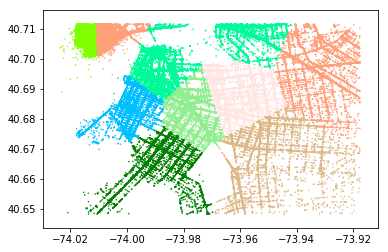

In [10]:
plotClusters(pickupDF)

------Scores of K-Mean Clustering on dataframe ----------
silhouette:0.51230270706
distortion: 39.7598933127
['rebeccapurple', 'skyblue', 'mediumblue', 'lightgrey', 'darkgreen', 'firebrick', 'blue', 'lightpink', 'darkmagenta', 'magenta']


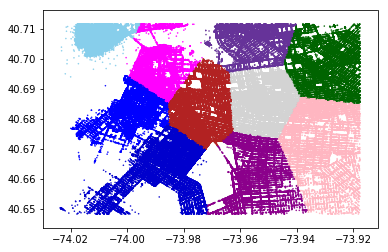

In [11]:
dropoffDF, kdropoff = kmeansOnLocation(dropoffDF)
plotClusters(dropoffDF)

In [12]:
dropoffDF.head()

,datetime,dropoff_datetime,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,trip_distance,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location,kmeans_cluster
0,2016-06-09 21:35:11,2016-06-09 21:35:11,-73.981636,40.670242,1,22.0,4.00,0.0,27.30,1,5.22,2016-06-09,-73.981636,40.670242,1,night,1320,"(-73.9816360474, 40.6702423096)",2
1,2016-06-09 21:23:55,2016-06-09 21:23:55,-74.011986,40.703773,1,17.0,3.65,0.0,21.95,1,5.10,2016-06-09,-74.011986,40.703773,1,night,1290,"(-74.0119857788, 40.7037734985)",1
2,2016-06-09 21:34:55,2016-06-09 21:34:55,-73.993607,40.666752,1,20.5,2.50,0.0,24.30,1,5.60,2016-06-09,-73.993607,40.666752,1,night,1320,"(-73.9936065674, 40.6667518616)",2
3,2016-06-09 21:22:19,2016-06-09 21:22:19,-73.983871,40.693539,1,10.0,3.39,0.0,14.69,1,2.02,2016-06-09,-73.983871,40.693539,1,night,1290,"(-73.98387146, 40.6935386658)",9
4,2016-06-09 21:36:56,2016-06-09 21:36:56,-73.989677,40.703846,1,21.0,2.50,0.0,24.80,1,6.01,2016-06-09,-73.989677,40.703846,1,night,1320,"(-73.9896774292, 40.7038459778)",9


In [13]:
def calculateTipsPerc(fare, tips):
    return tips/fare

def classifyTips(tipPerc):
    if tipPerc <= 0.05:
        return 1
    elif tipPerc <= 0.1:
        return 2
    elif tipPerc <= 0.15:
        return 3
    elif tipPerc <= 0.2:
        return 4
    elif tipPerc <= 0.25:
        return 5
    elif tipPerc <= 0.3:
        return 6
    elif tipPerc <= 0.35:
        return 7
    else:
        return 8

def tipPreparation(df):
    # preparing data frame for analysis: removing negative and 0 fare_amounts
    df = df[df['fare_amount'] >0]
    
    # creating tip column percentage
    tipsPerc = []
    for x, y in zip(df['fare_amount'].values, df['tip_amount'].values):
        tipsPerc.append(round(calculateTipsPerc(x, y), 2))
        
    df['tips_perc'] = tipsPerc
        
    # remove tips-perc that were more than 100%
    df = df[df['tips_perc'] <1]
    
    df['tipClass'] = [classifyTips(x) for x in df['tips_perc'].values]
    
    return df


def tipsHistPlot(df, col='tips_perc'):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 1, 0.1))
    ax.set_yticks(np.arange(0, 160000, 20000))
    plt.hist(df[col], bins=20)
    plt.grid()
    plt.show()

In [14]:
pickupDF = tipPreparation(pickupDF)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
pickupDF.head()

,datetime,pickup_datetime,pickup_longitude,pickup_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,...,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location,kmeans_cluster,tips_perc,tipClass
0,2016-06-09 21:06:38,2016-06-09 21:06:38,-74.016121,40.710899,1,5.0,2.00,0.0,8.30,1,...,2016-06-09,-74.016121,40.710899,1,night,1290,"(-74.0161209106, 40.710899353)",7,0.40,8
1,2016-06-09 21:09:53,2016-06-09 21:09:53,-74.008247,40.711269,1,10.0,3.39,0.0,14.69,1,...,2016-06-09,-74.008247,40.711269,1,night,1290,"(-74.0082473755, 40.7112693787)",1,0.34,7
2,2016-06-09 21:09:55,2016-06-09 21:09:55,-74.016251,40.711048,1,19.0,4.06,0.0,24.36,1,...,2016-06-09,-74.016251,40.711048,1,night,1290,"(-74.0162506104, 40.7110481262)",7,0.21,5
3,2016-06-09 21:06:00,2016-06-09 21:06:00,-74.003128,40.706345,1,20.0,2.20,0.0,23.50,1,...,2016-06-09,-74.003128,40.706345,1,night,1290,"(-74.0031280518, 40.7063446045)",1,0.11,3
4,2016-06-09 21:06:02,2016-06-09 21:06:02,-73.987724,40.700386,1,11.5,1.00,0.0,13.80,1,...,2016-06-09,-73.987724,40.700386,1,night,1290,"(-73.9877243042, 40.7003860474)",0,0.09,2


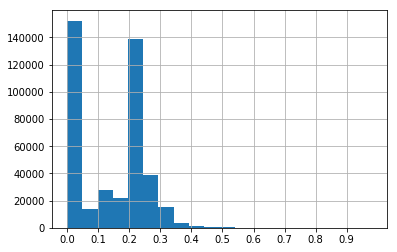

In [16]:
tipsHistPlot(pickupDF)

(array([ 154056.,   17845.,   27559.,       0.,   24188.,  137620.,
              0.,   35108.,   14104.,    5107.]),
 array([ 1. ,  1.7,  2.4,  3.1,  3.8,  4.5,  5.2,  5.9,  6.6,  7.3,  8. ]),
 <a list of 10 Patch objects>)

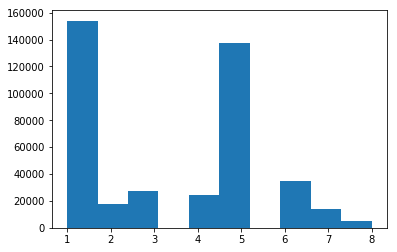

In [17]:
plt.hist(pickupDF['tipClass'])

In [18]:
pickupDF.columns

Index(['datetime', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'passenger_count', 'trip_distance', 'date', 'lon',
       'lat', 'weekday', 'time_of_day', 'min_since_midnight_group', 'location',
       'kmeans_cluster', 'tips_perc', 'tipClass'],
      dtype='object')

In [19]:
dt0 = pickupDF['datetime'].values[0]
dt1 = pickupDF['datetime'].values[415586]

x = dt1-dt0
days = x.astype('timedelta64[D]')
d = days / np.timedelta64(1, 'D')
print (d)

12.0


In [20]:
def createDummyDF(df):
    dummyColNames = ['payment_type', 'weekday', 'time_of_day', 'kmeans_cluster', 'passenger_count']
    df_with_dummies = pd.get_dummies(pickupDF, columns=dummyColNames)
    return df_with_dummies

In [21]:
pickupWithDummies = createDummyDF(pickupDF)
dropoffWithDummies = createDummyDF(dropoffDF)

In [22]:
def buildTipPredictionModel(df, alg='randomForest'):
    modelCols = ['trip_distance']
    modelCols.extend([col for col in df.columns if 'weekday_' in col])
    modelCols.extend([col for col in df.columns if 'payment_type_' in col])
    modelCols.extend([col for col in df.columns if 'passenger_count_' in col])
    modelCols.extend([col for col in df.columns if 'kmeans_cluster_' in col])
    modelCols.extend([col for col in df.columns if 'time_of_day_' in col])
    
    
    X = df[modelCols]
    target = df['tipClass']
    if alg=='randomForest':
        rfc = RandomForestClassifier()
        rfc.fit(X, target)
        return rfc

In [23]:
rfcdfwd = buildTipPredictionModel(pickupWithDummies)

In [24]:
rfcdfwd.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

Prediction:

In [25]:
pickupDF.head()

,datetime,pickup_datetime,pickup_longitude,pickup_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,...,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location,kmeans_cluster,tips_perc,tipClass
0,2016-06-09 21:06:38,2016-06-09 21:06:38,-74.016121,40.710899,1,5.0,2.00,0.0,8.30,1,...,2016-06-09,-74.016121,40.710899,1,night,1290,"(-74.0161209106, 40.710899353)",7,0.40,8
1,2016-06-09 21:09:53,2016-06-09 21:09:53,-74.008247,40.711269,1,10.0,3.39,0.0,14.69,1,...,2016-06-09,-74.008247,40.711269,1,night,1290,"(-74.0082473755, 40.7112693787)",1,0.34,7
2,2016-06-09 21:09:55,2016-06-09 21:09:55,-74.016251,40.711048,1,19.0,4.06,0.0,24.36,1,...,2016-06-09,-74.016251,40.711048,1,night,1290,"(-74.0162506104, 40.7110481262)",7,0.21,5
3,2016-06-09 21:06:00,2016-06-09 21:06:00,-74.003128,40.706345,1,20.0,2.20,0.0,23.50,1,...,2016-06-09,-74.003128,40.706345,1,night,1290,"(-74.0031280518, 40.7063446045)",1,0.11,3
4,2016-06-09 21:06:02,2016-06-09 21:06:02,-73.987724,40.700386,1,11.5,1.00,0.0,13.80,1,...,2016-06-09,-73.987724,40.700386,1,night,1290,"(-73.9877243042, 40.7003860474)",0,0.09,2


In [47]:
def getCountsFromDF(df):
    df['count'] = 1
    countDF = pd.DataFrame.groupby(df,by=['date', 'min_since_midnight_group', 'kmeans_cluster']).sum()
    countDF = countDF.reset_index()
    columns = ['date', 'min_since_midnight_group', 'kmeans_cluster', 'count']
    countDF = countDF[columns]
    return countDF

In [48]:
countPickupDF = getCountsFromDF(pickupDF)

[]

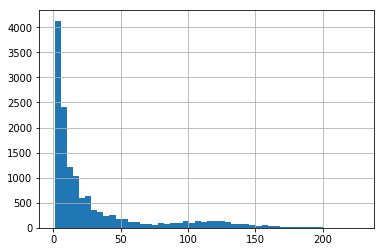

In [49]:
countPickupDF['count'].hist(bins=50).plot()

In [50]:
countPickupDF.head()

,date,min_since_midnight_group,kmeans_cluster,count
0,2016-06-01,30,0,20
1,2016-06-01,30,1,52
2,2016-06-01,30,2,12
3,2016-06-01,30,3,18
4,2016-06-01,30,4,13


In [51]:
countPickupDF["date;min_since_midnight"] = countPickupDF["date"].map(str) +';'+ countPickupDF["min_since_midnight_group"].map(str)

In [69]:
countPickupDF.head(12)

,date,min_since_midnight_group,kmeans_cluster,count,date;min_since_midnight
0,2016-06-01,30,0,20,2016-06-01;30
1,2016-06-01,30,1,52,2016-06-01;30
2,2016-06-01,30,2,12,2016-06-01;30
3,2016-06-01,30,3,18,2016-06-01;30
4,2016-06-01,30,4,13,2016-06-01;30
5,2016-06-01,30,5,20,2016-06-01;30
6,2016-06-01,30,6,12,2016-06-01;30
7,2016-06-01,30,7,37,2016-06-01;30
8,2016-06-01,30,8,17,2016-06-01;30
9,2016-06-01,30,9,9,2016-06-01;30


In [59]:
for c in range(0, 10):
    print(c)

0
1
2
3
4
5
6
7
8
9


In [213]:
def buildDataFramesForClusterDF(df):
    # dictionary for clusters
    pickups_brooklyn_clusters = {}
    date = {}
    min_since_midnight = {}
    count = {}
    d = {}
    dft = {}
    for c in range(0, 10):
        pickups_brooklyn_clusters[c] = df[df['kmeans_cluster'] == c]
        date[c] = pickups_brooklyn_clusters[c]['date'].values
        min_since_midnight[c] = pickups_brooklyn_clusters[c]['min_since_midnight_group'].values
        count[c] = pickups_brooklyn_clusters[c]['count'].values
        d = {'date': date[c], 'min_since_midnight': min_since_midnight[c], 'count': count[c]}
        dft[c] = pd.DataFrame(d)
    
    mergedft = pd.merge(dft[0], dft[1], on=['date', 'min_since_midnight'], how='inner', suffixes=('_0', '_1'))
    
    for c in range(2, 10):
        mergedft = pd.merge(mergedft, dft[c], on=['date', 'min_since_midnight'], how='inner', suffixes=('', '_'+str(c)))

    return dft, mergedft

In [214]:
pickupCountDict, mergedPickupCountClusters = buildDataFramesForClusterDF(countPickupDF)

In [215]:
#d.keys()

In [216]:
mergedPickupCountClusters.head(100)

,count_0,date,min_since_midnight,count_1,count,count_3,count_4,count_5,count_6,count_7,count_8,count_9
0,20,2016-06-01,30,52,12,18,13,20,12,37,17,9
1,20,2016-06-01,60,34,10,27,16,12,4,22,21,10
2,16,2016-06-01,90,28,10,15,11,18,5,19,19,6
3,6,2016-06-01,120,27,7,12,10,6,5,17,12,4
4,11,2016-06-01,150,16,5,10,5,12,5,14,7,3
5,3,2016-06-01,180,15,7,5,2,8,2,9,8,3
6,6,2016-06-01,210,5,3,5,3,5,1,4,9,1
7,10,2016-06-01,300,12,5,8,1,6,2,4,6,1
8,6,2016-06-01,330,11,3,7,1,5,11,14,2,3
9,27,2016-06-01,360,28,2,6,3,1,13,26,1,1


In [219]:
pickupCountDict[0].head()

,count,date,min_since_midnight
0,20,2016-06-01,30
1,20,2016-06-01,60
2,16,2016-06-01,90
3,6,2016-06-01,120
4,11,2016-06-01,150


In [263]:
def plots(input_df):
    
    fig = plt.figure(figsize=(20, 20))
    
    # histogram
    ax1 = fig.add_subplot(221)
    input_df['count'].hist(bins=25)
    plt.ylabel('frequency')
    plt.xlabel('#pickups')
    plt.title('Histogram of pickup counts')

    # scatterplot with colours

    ax3 = fig.add_subplot(222)
    ax3.scatter(range(len(input_df['count'])), input_df['count'], c=input_df['min_since_midnight'], s=10)
    plt.title('Pickup counts coloured according to minutes passed')

    # plot with mean and quantiles 
    df_grouped = input_df.groupby('min_since_midnight').sum()
    df_grouped['means'] = input_df.groupby('min_since_midnight').mean()
    df_grouped['quantile_5'] = input_df.groupby('min_since_midnight').quantile(0.05)
    df_grouped['quantile_95'] = input_df.groupby('min_since_midnight').quantile(0.95)

    x = df_grouped.index
    
    ax4 = fig.add_subplot(223)
    ax4.plot(x, df_grouped.means, c='pink')
    ax4.plot(x, df_grouped.quantile_5, c='green')
    ax4.plot(x, df_grouped.quantile_95, c='orange')
    plt.xlabel('minutes since midnight')
    plt.ylabel('# pickups')
    plt.title('Average, percentile 5 and percentile 95 pickups on a day')
    plt.legend()

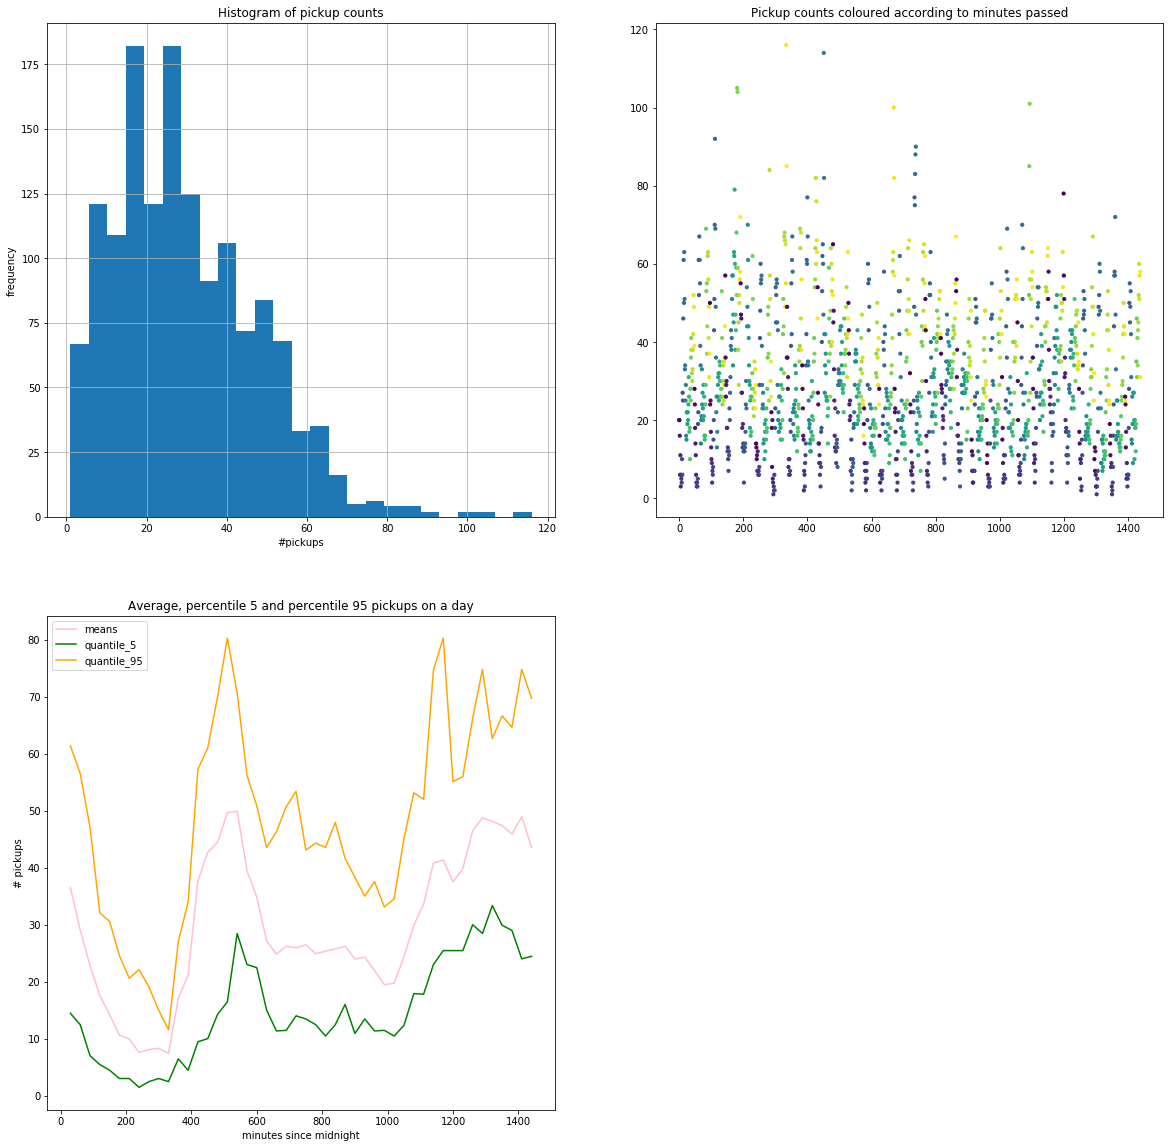

In [264]:
plots(pickupCountDict[0])

In [229]:
def buildLaggedFeatures(s,columns, lag=2,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 